In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>=0.99):
            print("\nReached 99% accuracy ")
            self.model.stop_training = True

callbacks = myCallback()

In [9]:
# Define dirs and files
train_dir = 'mldata/training/'
validation_dir = 'mldata/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

70
238
7
26


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescale val data
val_datagen = ImageDataGenerator(rescale = 1./255.)

#set batch Size
batch_size = 10

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = (300,300))

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = (300,300))


Found 308 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [5]:
#sample model
model = tf.keras.models.Sequential([
    #  input shape is size of the image 300x300 with 3 bytes color
    #first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten for the DNN
    tf.keras.layers.Flatten(),
    # hidden layerw/ 512 neurons
    tf.keras.layers.Dense(512, activation='relu'),
    # 1 output neuron. 0 for 'washover' and 1 for 'no wash'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
All_The_Metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='acc'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=All_The_Metrics)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              validation_data= validation_generator,
                              steps_per_epoch = total_train // batch_size,
                              epochs= 2,
                              validation_steps = total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/2
30/30 [==============================] - 150s 5s/step - loss: 0.4631 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 230.0000 - fn: 68.0000 - acc: 0.7718 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7925 - val_loss: 0.4228 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 23.0000 - val_fn: 7.0000 - val_acc: 0.7667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8602
Epoch 2/2
30/30 [==============================] - 150s 5s/step - loss: 0.4001 - tp: 6.0000 - fp: 1.0000 - tn: 233.0000 - fn: 58.0000 - acc: 0.8020 - precision: 0.8571 - recall: 0.0938 - auc: 0.8370 - val_loss: 0.3993 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 23.0000 - val_fn: 6.0000 - val_acc: 0.8000 - val_precision: 1.0000 - val_recall: 0.1429 - val_auc: 0.8944


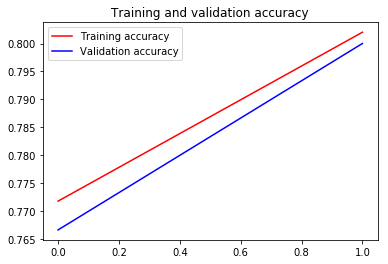

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [14]:
#Look and convolutions
#look at prediction successes and failures


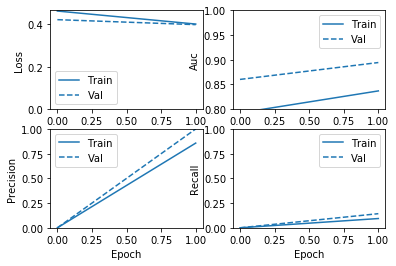

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)
